# PART 1. Data Pre-processing

## Step 0. Fire the system

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

## Step 1. Read data

In [3]:
# Importing Training Set
dataset_train = pd.read_csv('GOOG.csv')

dataset_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


In [4]:
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (4006, 7)
All timestamps == 4006
Featured selected: ['Open', 'High', 'Low', 'Close', 'Adj Close']


## Step 2. Data pre-processing
Removing all commas and convert data to matrix shape format.

In [5]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(len(dataset_train)):
        dataset_train.at[j, i] = dataset_train.at[j, i].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()  # or dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))

training_set

Shape of training set == (4006, 5).


array([[  49.813286,   51.835709,   47.800831,   49.982655,   49.982655],
       [  50.316402,   54.336334,   50.062355,   53.95277 ,   53.95277 ],
       [  55.168217,   56.528118,   54.321388,   54.495735,   54.495735],
       ...,
       [1523.130005, 1535.329956, 1498.      , 1513.640015, 1513.640015],
       [1500.      , 1518.689941, 1486.310059, 1518.      , 1518.      ],
       [1521.619995, 1523.439941, 1498.420044, 1515.550049, 1515.550049]])

In [6]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-1.27195197],
       [-1.27058974],
       [-1.25745309],
       ...,
       [ 2.71716347],
       [ 2.65453724],
       [ 2.713075  ]])

In [7]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (3857, 90, 4).
y_train shape == (3857, 1).


# PART 2. Create a model. Training

## Step 3. Building the LSTM based Neural Network

In [8]:
# Import Libraries and packages from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam

In [9]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

/Users/junqinghe/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Step 4. Start training

In [10]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2130
Epoch 1: val_loss improved from inf to 0.33134, saving model to weights.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.1974 - val_loss: 0.3313 - learning_rate: 0.0100
Epoch 2/30
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0377
Epoch 2: val_loss improved from 0.33134 to 0.24228, saving model to weights.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0374 - val_loss: 0.2423 - learning_rate: 0.0100
Epoch 3/30
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0311
Epoch 3: val_loss did not improve from 0.24228
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0311 - val_loss: 0.2806 - learning_rate: 0.0100
Epoch 4/30
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0376
Epoch 4: val_loss improved from 0.24228 to 0.15848, saving model to weights.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0373 - val_loss: 0.1585 - learning_rate: 0.0100
Epoch 5/30
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0237
Epoch 29: val_loss did not improve from 0.10095
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0236 - val_loss: 0.1139 - learning_rate: 0.0100
Epoch 30/30
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0252
Epoch 30: val_loss improved from 0.10095 to 0.09421, saving model to weights.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0251 - val_loss: 0.0942 - learning_rate: 0.0100
CPU times: user 36.8 s, sys: 20.4 s, total: 57.2 s
Wall time: 36.1 s


# PART 3. Make future predictions

In [11]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

## Step 5. Make predictions for future dates

In [12]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [13]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Open
2005-08-01,156.489304
2005-08-02,156.957199
2005-08-03,157.269363


## Step 6. Visualize the Predictions

In [23]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

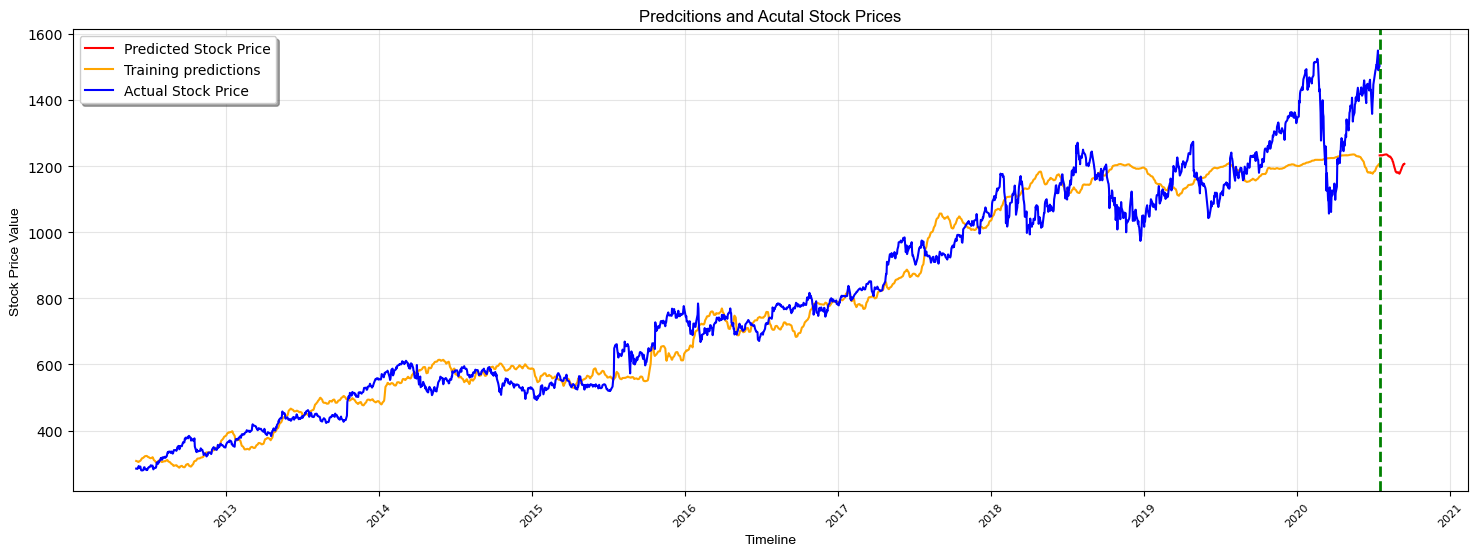

In [24]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 18, 6

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()